In [2]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    npimg = np.array(img)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Files already downloaded and verified
Files already downloaded and verified


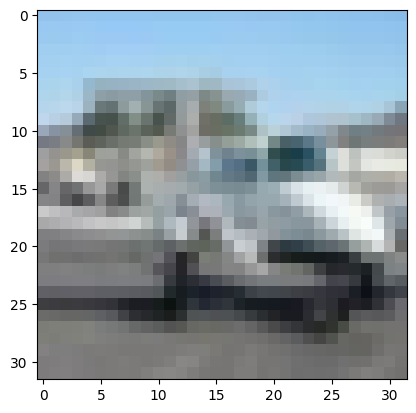

In [3]:
import random

from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10


EPOCHS = 10
BATCH_SIZE = 32

transform = transforms.Compose([
    transforms.ToTensor()
])
trainset = CIFAR10(root="./data", train=True, download=True, transform=transform)
testset = CIFAR10(root="./data", train=False, download=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
imshow(random.choice(trainset)[0])

In [4]:
import torch


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torchvision import models


net = models.googlenet().to(device)
criterion = CrossEntropyLoss()
optimizer = SGD(net.parameters(), lr=0.001, momentum=0.9)
for epoch in range(1, EPOCHS + 1):
    running_loss = 0
    for i, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch}: loss = {running_loss/len(train_loader):.3f}")

/home/diego/miniconda3/envs/mna_py_310/lib/python3.10/site-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Epoch 1: loss = 1.716
Epoch 2: loss = 1.233
Epoch 3: loss = 1.010
Epoch 4: loss = 0.852
Epoch 5: loss = 0.737
Epoch 6: loss = 0.650
Epoch 7: loss = 0.570
Epoch 8: loss = 0.503
Epoch 9: loss = 0.439
Epoch 10: loss = 0.388


In [6]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        predicted = torch.max(outputs.logits, 1).indices
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Accuracy: {100 * correct / total:.3f}")

Accuracy: 76.320


# Feature extraction

In [7]:
import types
from typing import Optional, Tuple

from torch import Tensor


def forward(self, x: Tensor) -> Tuple[Tensor, Optional[Tensor], Optional[Tensor]]:
        # N x 3 x 224 x 224
        x = self.conv1(x)
        # N x 64 x 112 x 112
        x = self.maxpool1(x)
        # N x 64 x 56 x 56
        x = self.conv2(x)
        # N x 64 x 56 x 56
        x = self.conv3(x)
        # N x 192 x 56 x 56
        x = self.maxpool2(x)

        # N x 192 x 28 x 28
        x = self.inception3a(x)
        # N x 256 x 28 x 28
        x = self.inception3b(x)
        # N x 480 x 28 x 28
        x = self.maxpool3(x)
        # N x 480 x 14 x 14
        x = self.inception4a(x)
        # N x 512 x 14 x 14
        aux1: Optional[Tensor] = None
        if self.aux1 is not None:
            if self.training:
                aux1 = self.aux1(x)

        x = self.inception4b(x)
        # N x 512 x 14 x 14
        x = self.inception4c(x)
        # N x 512 x 14 x 14
        x = self.inception4d(x)
        # N x 528 x 14 x 14
        aux2: Optional[Tensor] = None
        if self.aux2 is not None:
            if self.training:
                aux2 = self.aux2(x)

        x = self.inception4e(x)
        # N x 832 x 14 x 14
        x = self.maxpool4(x)
        # N x 832 x 7 x 7
        x = self.inception5a(x)
        # N x 832 x 7 x 7
        x = self.inception5b(x)
        # N x 1024 x 7 x 7

        x = self.avgpool(x)
        # N x 1024 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 1024
        #x = self.dropout(x)
        #x = self.fc(x)
        # N x 1000 (num_classes)
        return x, aux2, aux1

In [9]:
feature_extractor = models.googlenet()
f_type = types.MethodType(forward, feature_extractor)
feature_extractor._forward = f_type
feature_extractor = feature_extractor.to(device)
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = feature_extractor(images)
outputs[0]

tensor([[1.3387, 0.7722, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6227, 0.0000,  ..., 1.2152, 0.6688, 0.0000],
        [1.1254, 0.0000, 1.8499,  ..., 0.5868, 0.5592, 0.7101],
        ...,
        [0.6433, 1.5933, 0.0000,  ..., 1.7285, 1.0692, 0.0000],
        [0.0768, 0.0000, 0.0000,  ..., 0.0000, 0.8401, 0.6315],
        [1.4773, 0.3574, 1.8934,  ..., 0.0000, 1.4545, 0.0000]],
       device='cuda:0')